In [1]:
import os
from drift_detectors import *
import warnings
warnings.filterwarnings('ignore')

D:\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = "C:/Users/luiz_/Projects/DataStreams/Test/DataStreams-index/benchmark_real"
files = os.listdir(path)
datasets = [x[:-4] for x in files]

In [3]:
table = pd.DataFrame(columns=["IBDD", "IKS", "WRS", "ADWIN", "TOPLINE", "BASELINE"], index=[datasets])
window_size = 300 #window parameter to build the images for comparison
train_size = 500
table

,IBDD,IKS,WRS,ADWIN,TOPLINE,BASELINE
1CDT,NaN,NaN,NaN,NaN,NaN,NaN


Dataset: 1CDT
IKS Running...
Example 15500/15500 - drifts: [349, 753, 1143, 1640, 2120, 2650, 3182, 3612, 4081, 4465, 4927, 5299, 5771, 6300, 6656, 7166, 7691, 8494, 8899, 9379, 9930, 10410, 10797, 11226, 11616, 12072, 12566, 12883, 13394, 13848, 14436, 14833, 15241]
Finished!
33 drifts detected at [349, 753, 1143, 1640, 2120, 2650, 3182, 3612, 4081, 4465, 4927, 5299, 5771, 6300, 6656, 7166, 7691, 8494, 8899, 9379, 9930, 10410, 10797, 11226, 11616, 12072, 12566, 12883, 13394, 13848, 14436, 14833, 15241]
Average classification accuracy: 99.87%
Time per example: 0.02 sec
Total time: 304.33 sec


,IBDD,IKS,WRS,ADWIN,TOPLINE,BASELINE
1CDT,NaN,99.870968,NaN,NaN,NaN,NaN


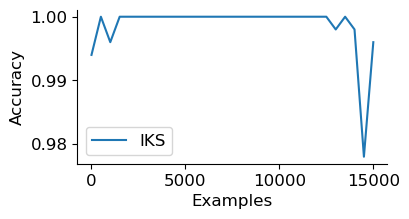

In [4]:
for file in files:
    stream = pd.read_csv(path + "/" + file, header=None, index_col=False,sep=',')
    stream.iloc[:, -1].replace(1, int(0), inplace=True)
    stream.iloc[:, -1].replace(2, int(1), inplace=True)
    train = stream.iloc[:train_size].reset_index(drop=True)
    test = stream.iloc[train_size:].reset_index(drop=True)

    print(f"Dataset: {file[:-4]}")
    for detector in ["IKS", "IBDD", "WRS", "ADWIN", "BASELINE","TOPLINE"]:
        if detector == "IKS":
            threshold = 1.95
            [drifts, acc_vector, mean_acc, time] = IKS(train, test, window_size, threshold)
        elif detector == "IBDD":
            epsilon = 3
            [drifts, acc_vector, mean_acc, time] = IBDD(train, test, window_size, epsilon)
        elif detector == "WRS":
            threshold = 0.001
            [drifts, acc_vector, mean_acc, time] = WRS(train, test, window_size, threshold)
        elif detector == "ADWIN":
            [drifts, acc_vector, mean_acc, time] = Adwin(train, test, window_size)
        elif detector == "TOPLINE":
            [mean_acc, acc_vector, time] = topline_classifier(train, test, window_size)
        elif detector == "BASELINE":
            [mean_acc, acc_vector, time] = baseline_classifier(train, test)
        print("=======================")
            
        table.loc[[file[:-4]], [detector]] = round(mean_acc)
table

    

# INCREMENTAL KOLMOGOROV-SMIRNOV (IKS):

In [5]:
FILENAME_TRAIN = 'benchmark_real/Yoga_TRAIN.data'
FILENAME_TEST = 'benchmark_real/Yoga_TEST.data'
threshold = 1.12
[drifts, acc_vector, mean_acc, time] = IKS(FILENAME_TRAIN, FILENAME_TEST, window_size, threshold)

AttributeError: 'str' object has no attribute 'iloc'

# IMAGE-BASED DRIFT DETECTION (IBDD):

In [ ]:
epsilon = 3 #number of MSD values above/below threshold
[drifts, acc_vector, mean_acc, time] = IBDD(FILENAME_TRAIN, FILENAME_TEST, window_size, epsilon)

# BASELINE:

In [ ]:
[mean_acc, acc_vector, time] = baseline_classifier(FILENAME_TRAIN, FILENAME_TEST)

# TOPLINE:

In [ ]:
[mean_acc, acc_vector, time] = topline_classifier(FILENAME_TRAIN, FILENAME_TEST, window_size)

# WILCOXON-RANK SUM (WRS):

In [ ]:
threshold = 0.001
[drifts, acc_vector, mean_acc, time] = wrs_test(FILENAME_TRAIN, FILENAME_TEST, window_size, threshold)